In [1]:
import numpy as np
import pandas as pd

import torch
from datasets import load_dataset
from torch import nn
from tqdm import tqdm, trange
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from torch.utils.data import DataLoader
import pickle
from aiirw import AI_IRW

from scipy.spatial.distance import mahalanobis, cdist

import matplotlib.pyplot as plt
from _ood_classifier import OODDetector

import seaborn as sns
sns.set_style('white')

In [2]:
tokenizer = AutoTokenizer.from_pretrained("fabriceyhc/bert-base-uncased-imdb")

model = AutoModelForSequenceClassification.from_pretrained("fabriceyhc/bert-base-uncased-imdb")


In [3]:
dataset = load_dataset("imdb")



Found cached dataset imdb (/home/onyxia/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
class LatentBert(nn.Module):

    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.N = len(self.base_model.bert.encoder.layer)

    def to(self, device):
        self.base_model.to(device)
        return self

    def forward(self, x):
        
        x = self.base_model.bert.embeddings(x)
        latent_reps = torch.zeros((x.shape[0], x.shape[2],self.N)
        )
        for i, layer in enumerate(self.base_model.bert.encoder.layer) :
            x = layer(x)[0]
            latent_reps[:,:,i] = x[:,0,:] #Pooling is done by taking the hidden state of first token (cf Bert implementation)
        
        x_ = self.base_model.bert.pooler(x)
        x = self.base_model.classifier(x_)
                
        return {"embeddings" : torch.mean(latent_reps, axis=-1), "logits": x, "attention": x_}
        

In [5]:
lb = LatentBert(base_model=model).to('cuda')

In [43]:
train_in_dl = DataLoader(dataset['train'], batch_size=8)

environ 14min

In [44]:
embds = []
logits = []
attns = []
for batch in tqdm(train_in_dl):
    data = batch['text']
    tk_batch = tokenizer(data,return_tensors="pt", truncation=True, padding=True)['input_ids'].to('cuda')
    outputs = lb.forward(tk_batch, return_logits=True)
    embds.append(outputs['embeddings'].cpu().detach())
    logits.append(outputs['logits'].cpu().detach())
    attns.append(outputs['attention'].cpu().detach())

100%|██████████| 3125/3125 [12:05<00:00,  4.31it/s]


In [45]:
with open('nlp_data/embeddings_imbd_train.pkl', 'wb') as f:
    pickle.dump(embds, f)

with open('nlp_data/logits_imdb_train.pkl', 'wb') as f:
    pickle.dump(logits, f)
    
with open('nlp_data/attns_imdb_train.pkl', 'wb') as f:
    pickle.dump(attns, f)

In [6]:
oods = dict(multi30k = ["nlphuji/flickr30k"],
sst2 = ["sst2"],
wmt16 = ['wmt16', 'de-en'],
newsgroup = ["SetFit/20_newsgroups"])

collate_fns = dict(
    multi30k= lambda x : x[1]['caption'][0], 
    sst2= lambda x: [el['sentence'] for el in x], 
    wmt16 = lambda x : [el['translation']['en'] for el in x], 
    newsgroup=lambda x : [el['text'].replace('\n', ' ').replace("\\", '') for el in x ]
)

batch_sizes = dict(
    multi30k= 16, 
    sst2= 16, 
    wmt16 = 16, 
    newsgroup=4
)


In [8]:
for ds_n, ds in oods.items():
    out_dataset  =  load_dataset(*ds)
    ood_dl = DataLoader(dataset=out_dataset['test'],
                        batch_size=batch_sizes[ds_n], 
                        collate_fn= collate_fns[ds_n], #for flickr
                        )
    embds = []
    logits = []
    attns = []
    for batch in tqdm(ood_dl):
        tk_batch = tokenizer(batch,return_tensors="pt", truncation=True, padding=True)['input_ids'].to('cuda')
        outputs = lb.forward(tk_batch)
        embds.append(outputs['embeddings'].cpu().detach())
        logits.append(outputs['logits'].cpu().detach())
        attns.append(outputs['attention'].cpu().detach())

    with open(f'embeddings_ood_test_{ds_n}.pkl', 'wb') as f:
        pickle.dump(embds, f)

    with open(f'logits_ood_test_{ds_n}.pkl', 'wb') as f:
        pickle.dump(logits, f)

    with open(f'attns_ood_test_{ds_n}.pkl', 'wb') as f:
        pickle.dump(attns, f)

Found cached dataset flickr30k (/home/onyxia/.cache/huggingface/datasets/nlphuji___flickr30k/TEST/1.1.0/6adb9ab2367c57c3e81e76ecaecb8047ea00c33dccf9da10455037f32ec43382)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1939/1939 [03:20<00:00,  9.68it/s]
Found cached dataset sst2 (/home/onyxia/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 114/114 [00:04<00:00, 22.85it/s]
Found cached dataset wmt16 (/home/onyxia/.cache/huggingface/datasets/wmt16/de-en/1.0.0/746749a11d25c02058042da7502d973ff410e73457f3d305fc1177dc0e8c4227)


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 188/188 [00:08<00:00, 21.02it/s]
Found cached dataset json (/home/onyxia/.cache/huggingface/datasets/SetFit___json/SetFit--20_newsgroups-f9362e018b6adf67/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 1883/1883 [02:44<00:00, 11.43it/s]


In [50]:
test_in_dl = DataLoader(dataset['test'], batch_size=8)

environ 14 min

In [52]:
embds = []
logits = []
attns = []
for batch in tqdm(test_in_dl):
    data = batch['text']
    tk_batch = tokenizer(data,return_tensors="pt", truncation=True, padding=True)['input_ids'].to('cuda')
    outputs = lb.forward(tk_batch, return_logits=True)
    embds.append(outputs['embeddings'].cpu().detach())
    logits.append(outputs['logits'].cpu().detach())
    attns.append(outputs['attention'].cpu().detach())

100%|██████████| 3125/3125 [11:58<00:00,  4.35it/s]


In [53]:
with open('nlp_data/embeddings_test.pkl', 'wb') as f:
    pickle.dump(embds, f)

with open('nlp_data/logits_test.pkl', 'wb') as f:
    pickle.dump(logits, f)

with open('nlp_data/attns_test.pkl', 'wb') as f:
    pickle.dump(attns, f)

## Loading

In [2]:
with open('nlp_data/embeddings_train.pkl', 'rb') as f:
    embd_train = pickle.load(f)

with open('nlp_data/logits_train.pkl', 'rb') as f:
    logit_train = pickle.load(f)

In [3]:
with open('nlp_data/embeddings_ood_test_sst2.pkl', 'rb') as f:
    embd_ood = pickle.load(f)

with open('nlp_data/logits_ood_test_sst2.pkl', 'rb') as f:
    logit_ood = pickle.load(f)

In [5]:
with open('nlp_data/embeddings_imdb_test.pkl', 'rb') as f:
    embd_test = pickle.load(f)

with open('nlp_data/logits_imdb_test.pkl', 'rb') as f:
    logit_test = pickle.load(f)

In [6]:
logit_train = torch.cat(logit_train).numpy()
embd_train = torch.cat(embd_train).numpy()

train_distrib  = {l: embd_train[np.where(np.argmax(logit_train, axis=-1)==l)] for l in range(logit_train.shape[1])}


In [7]:
logit_test = torch.cat(logit_test).numpy()
embd_test = torch.cat(embd_test).numpy()

test_distrib  = {l: embd_test[np.where(np.argmax(logit_test, axis=-1)==l)] for l in range(logit_test.shape[1])}


In [8]:
logit_ood = torch.cat(logit_ood).numpy()
embd_ood = torch.cat(embd_ood).numpy()

ood_distrib  = {l: embd_ood[np.where(np.argmax(logit_ood, axis=-1)==l)] for l in range(logit_ood.shape[1])}


In [9]:
def MahaDist(X, distrib):
    m = np.mean(distrib, axis=0).reshape(1, 768)
    VI= np.linalg.inv(np.cov(distrib.T))
    return cdist(XA = X, XB = m, metric = 'mahalanobis', VI=VI)

In [15]:
scores_ood = np.concatenate((AI_IRW(X=train_distrib[0], AI=True, X_test=ood_distrib[0], n_dirs=1000) ,AI_IRW(X=train_distrib[1], AI=True, X_test=ood_distrib[1], n_dirs=1000)))
#scores_ood = np.concatenate((MahaDist(X=ood_distrib[0], distrib=train_distrib[0]) ,MahaDist(X=ood_distrib[1], distrib=train_distrib[0])))[:,0]

In [16]:
scores_test = np.concatenate((AI_IRW(X=train_distrib[0], AI=True, X_test=test_distrib[0], n_dirs=1000) ,AI_IRW(X=train_distrib[1], AI=True, X_test=test_distrib[1], n_dirs=1000)))
#scores_test = np.concatenate((MahaDist(X=test_distrib[0], distrib=train_distrib[0]) ,MahaDist(X=test_distrib[1], distrib=train_distrib[1])))[:,0]


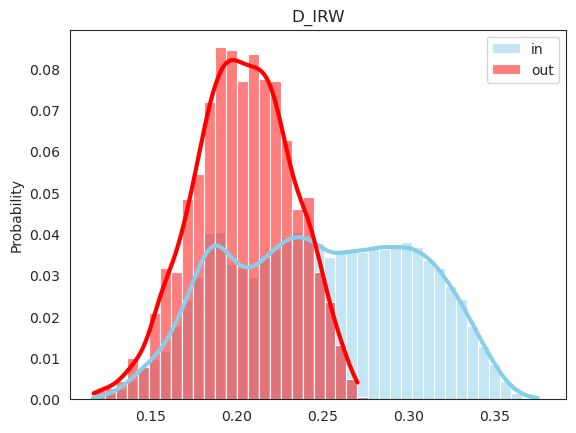

In [17]:
#c = 2*np.max(np.concatenate((scores_ood, scores_test)))
sns.histplot(scores_test, label='in', binwidth=6.4e-3, color='skyblue',kde=True, stat='probability',  line_kws={"lw":3})
sns.histplot(scores_ood, label='out',binwidth=6.4e-3, color='red', kde=True, stat='probability',  line_kws={"lw":3})
plt.legend()
plt.title("D_IRW")
plt.show()

In [23]:
tau=50
clf_0 = OODDetector(tau=tau, similarity='mahalanobis')
clf_1 = OODDetector(tau=tau, similarity='mahalanobis')

In [24]:
clf_0.fit(train_distrib[0])
clf_1.fit(train_distrib[1])

In [25]:
(clf_1.score(X_1, y_1)+clf_0.score(X_0, y_0))/2

0.9878325382885362

In [9]:
X_0 =  np.concatenate((ood_distrib[0], test_distrib[0]))
y_0 =   np.concatenate((np.ones((ood_distrib[0].shape[0])), np.zeros((test_distrib[0].shape[0]))))

X_1 =  np.concatenate((ood_distrib[1], test_distrib[1]))
y_1 =   np.concatenate((np.ones((ood_distrib[1].shape[0])), np.zeros((test_distrib[1].shape[0]))))

X_ = np.concatenate((logit_ood, logit_test))
y_ = np.concatenate((np.ones(logit_ood.shape[0]), np.zeros(logit_test.shape[0])))

In [16]:
clf_MSP = OODDetector(tau=5e-2, similarity='MSP').fit()

In [19]:
balanced_accuracy_score(clf_MSP.predict(X_), y_)

0.5099720405094432

ValueError: x is neither increasing nor decreasing : [0 0 0 ... 0 0 0].

In [20]:
from sklearn.metrics import balanced_accuracy_score, auc

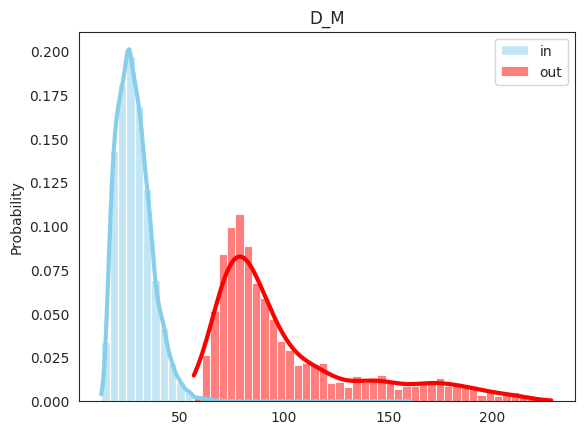

In [ ]:
#Maha
binwidth = 4
sns.histplot(scores_test, label='in', binwidth=binwidth, color='skyblue',kde=True, stat='probability',  line_kws={"lw":3})
sns.histplot(scores_ood, label='out',binwidth=binwidth, color='red', kde=True, stat='probability',  line_kws={"lw":3})
plt.legend()
plt.title("D_M")
plt.show()

In [38]:
#import random search from sklearn
from sklearn.model_selection import RandomizedSearchCV
#import shuffle from sklearn
from sklearn.utils import shuffle

X_0, y_0 = shuffle(X_0, y_0)
X_1, y_1 = shuffle(X_1, y_1)
X_, y_ = shuffle(X_, y_)

# Create the parameter grid based on the results of random search, tau follows a gaussian centered in 50 with std 10
param_grid = {
    'tau': np.random.uniform(0, 10, 100), 
    'similarity': ['mahalanobis'],
    'base_distribution' : [train_distrib[0]]
}

# Create a based model
clf = OODDetector(similarity='mahalanobis', tau=50, base_distribution=train_distrib[0])

# Instantiate the grid search model
grid_search = RandomizedSearchCV(estimator = clf, param_distributions = param_grid,
                            cv = 5, n_jobs = -1, verbose = 0, scoring='balanced_accuracy')


In [39]:
grid_search.fit(X_0, y_0)
print(grid_search.best_params_)

{'tau': 1.7822930975848006, 'similarity': 'mahalanobis', 'base_distribution': array([[ 0.1655158 ,  0.19259338, -0.05701194, ..., -0.04087529,
         0.06450007,  0.27201617],
       [ 0.26176506,  0.13326405,  0.04254614, ..., -0.02392149,
         0.06750306,  0.20914446],
       [ 0.16050506, -0.07738341,  0.21776502, ..., -0.1432903 ,
        -0.04918719, -0.1345499 ],
       ...,
       [-0.07087212, -0.27570873,  0.08874413, ..., -0.14185995,
        -0.05530067, -0.18070912],
       [-0.13870718, -0.08804137, -0.18017988, ..., -0.1654126 ,
        -0.06333739, -0.11101169],
       [ 0.00867541, -0.23554574,  0.14202845, ..., -0.29557773,
        -0.16673136, -0.346024  ]], dtype=float32)}


In [40]:
grid_search.best_score_

0.5

torch.Size([1, 768])